In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wholesale = pd.read_csv('../DATASETS/part4/wholesale.csv')
# Print the header of the `wholesale` dataset
wholesale.drop(['Channel', 'Region'], axis=1, inplace=True)
print(wholesale.head())

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185


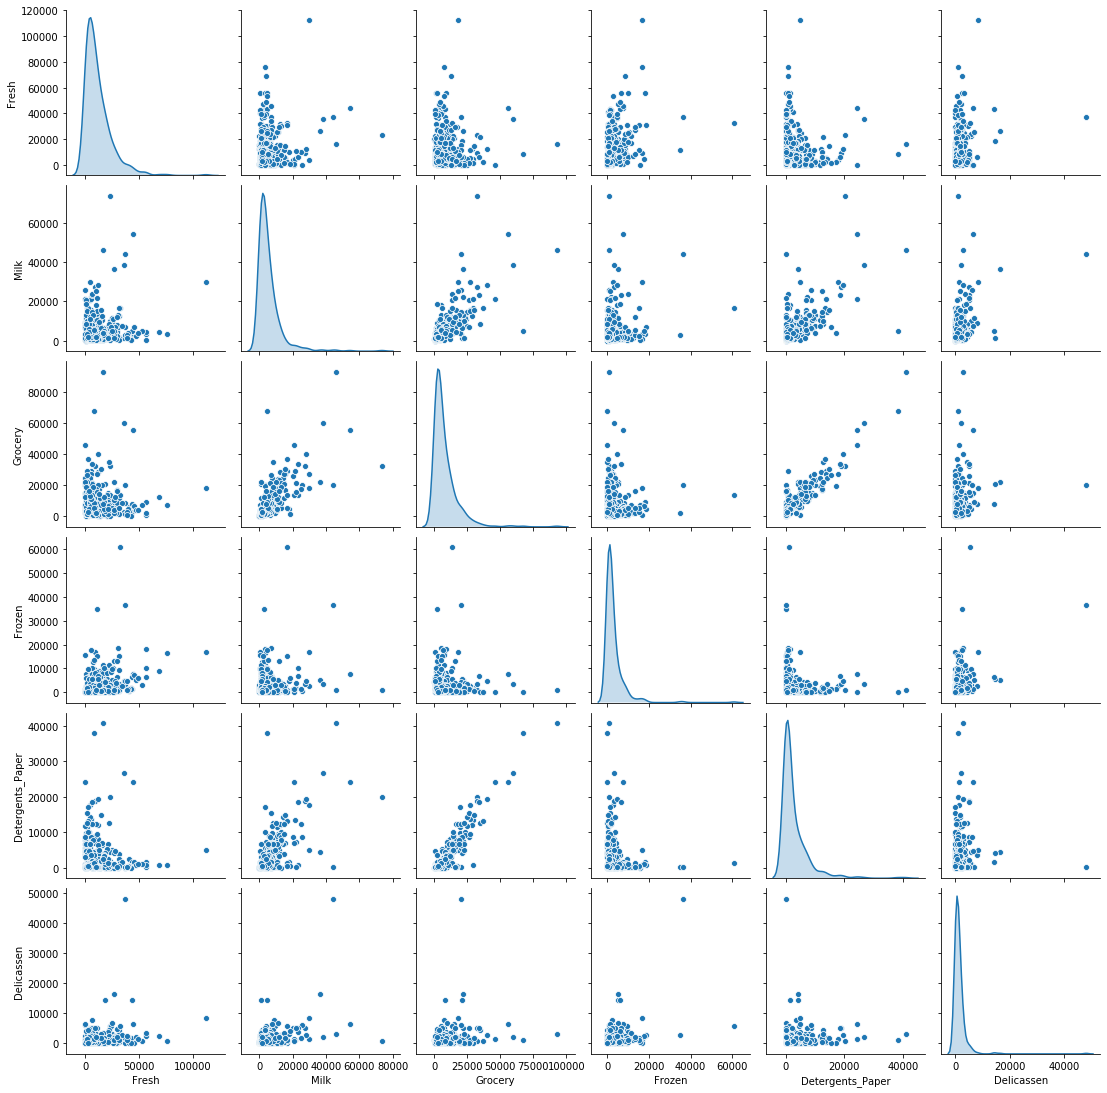

In [3]:


# Plot the pairwise relationships between the variables
sns.pairplot(wholesale, diag_kind='kde')

# Display the chart
plt.show()

In [4]:
averages = wholesale.mean()
std_devs = wholesale.std()

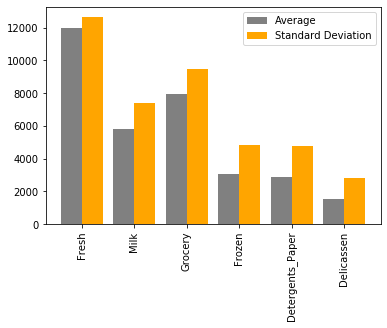

In [5]:
# Create column names list and same length integer list
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

# Plot the averages data in gray and standard deviations in orange 
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)

# Add x-axis labels and rotate
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)

# Add the legend and display the chart
plt.legend()
plt.show()

In [6]:
from scipy import stats

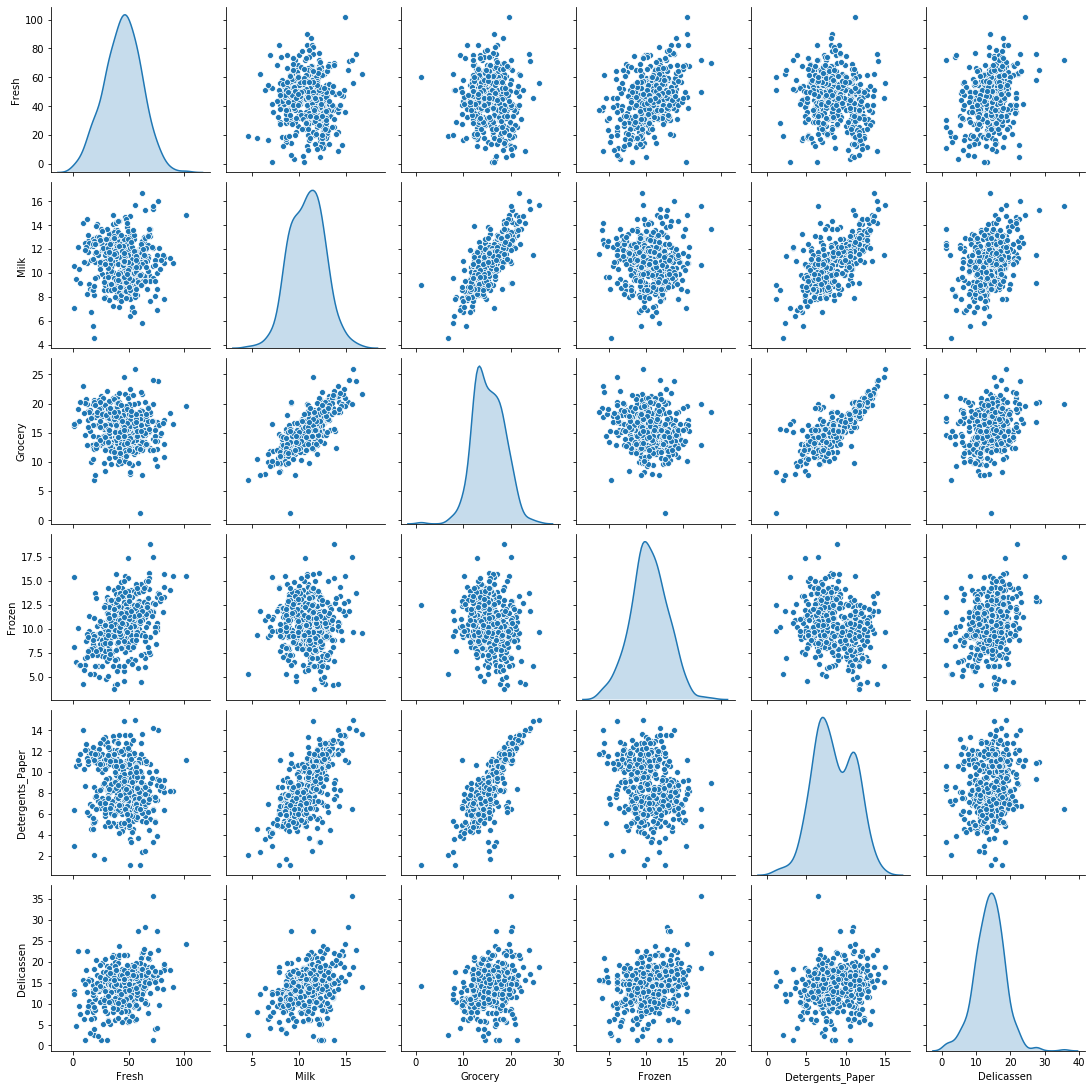

In [7]:
# Define custom Box Cox transformation function
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

# Apply the function to the `wholesale` dataset
wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

# Plot the pairwise relationships between the transformed variables 
sns.pairplot(wholesale_boxcox, diag_kind='kde')

# Display the chart
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [9]:
# Fit the initialized `scaler` instance on the Box-Cox transformed dataset
scaler.fit(wholesale_boxcox)

# Transform and store the scaled dataset as `wholesale_scaled`
wholesale_scaled = scaler.transform(wholesale_boxcox)

# Create a `pandas` DataFrame from the scaled dataset
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                       index=wholesale_boxcox.index,
                                       columns=wholesale_boxcox.columns)

# Print the mean and standard deviation for all columns
print(wholesale_scaled_df.agg(['mean','std']).round())

      Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
mean   -0.0   0.0     -0.0    -0.0              -0.0         0.0
std     1.0   1.0      1.0     1.0               1.0         1.0


In [10]:
from sklearn.cluster import KMeans

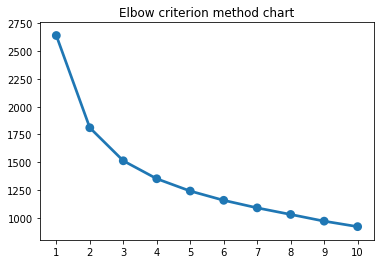

In [11]:
# Create empty sse dictionary
sse = {}

# Fit KMeans algorithm on k values between 1 and 11
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

# Add the title to the plot
plt.title('Elbow criterion method chart')

# Create and display a scatter plot
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [19]:
# Import `KMeans` module
# Initialize `KMeans` with 4 clusters
kmeans=KMeans(n_clusters=3, random_state=123)

# Fit the model on the pre-processed dataset
kmeans.fit(wholesale_scaled_df)

# Assign the generated labels to a new column
wholesale_kmeans3 = wholesale.assign(segment = kmeans.labels_)
print(wholesale_kmeans3.head())

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  segment
0  12669  9656     7561     214              2674        1338        2
1   7057  9810     9568    1762              3293        1776        2
2   6353  8808     7684    2405              3516        7844        0
3  13265  1196     4221    6404               507        1788        0
4  22615  5410     7198    3915              1777        5185        0


In [24]:
# Import the non-negative matrix factorization module
from sklearn.decomposition import NMF

# Initialize NMF instance with 4 components
nmf = NMF(3)

# Fit the model on the wholesale sales data
nmf.fit(wholesale)

# Extract the components 
components = pd.DataFrame(data=nmf.components_, columns=wholesale.columns)

print(components)

        Fresh        Milk     Grocery      Frozen  Detergents_Paper  \
0  642.621733    0.000000   40.241499    0.000000          0.000000   
1    1.151420  249.056414  410.032578    0.000000        185.835443   
2    0.569411  212.534786   15.247241  350.253238          0.000000   

   Delicassen  
0    3.069453  
1   22.050947  
2  129.701443  


           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0        25528.0   6406.0   6272.0  7513.0            1091.0      3401.0
1         9735.0   2017.0   2613.0  2341.0             490.0       726.0
2         6714.0  10356.0  15939.0  1319.0            7092.0      1424.0


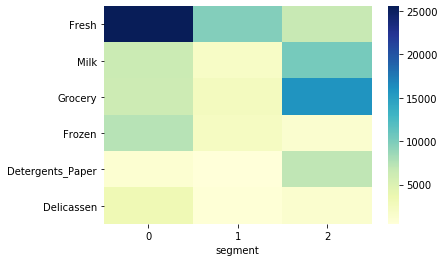

In [21]:
# Group by the segment label and calculate average column values
kmeans3_averages = wholesale_kmeans3.groupby(['segment']).mean().round(0)

# Print the average column values per each segment
print(kmeans3_averages)

# Create a heatmap on the average column values per each segment
sns.heatmap(kmeans3_averages.T, cmap='YlGnBu')

# Display the chart
plt.show()

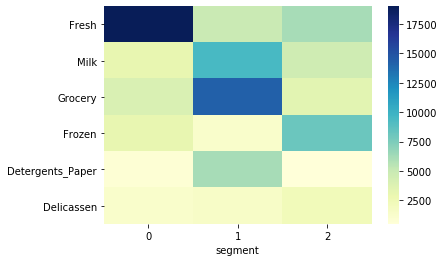

In [25]:
# Create the W matrix
W = pd.DataFrame(data=nmf.transform(wholesale), columns=components.index)
W.index = wholesale.index

# Assign the column name where the corresponding value is the largest
wholesale_nmf3 = wholesale.assign(segment = W.idxmax(axis=1))

# Calculate the average column values per each segment
nmf3_averages = wholesale_nmf3.groupby('segment').mean().round(0)

# Plot the average values as heatmap
sns.heatmap(nmf3_averages.T, cmap='YlGnBu')

# Display the chart
plt.show()